# Comprehensive NLP Analysis of Interview Transcripts on Menstrual Health
Topic: Do University Students Feel Comfortable Discussing Menstruation in Academic Spaces? 

This study explores whether university students feel comfortable discussing menstruation within academic spaces, aiming to understand the social, cultural, and institutional factors that influence openness around this often-stigmatized topic.

This notebook performs an end-to-end NLP analysis on interview transcripts discussing menstrual health and related social topics. It includes data ingestion from docx. file formats, flexible Q/A extraction, text preprocessing, sentiment analysis using VADER and TextBlob, topic modeling with LDA and NMF, semantic clustering with UMAP and HDBSCAN, and multiple visualizations such as word clouds, sentiment distributions, and topic distributions.

## Importing Libraries and Setting-up Environment

In [58]:
# %%bash
# NLTK downloads 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
# Imports and constants
import os, re, glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import joblib

# NLP libs
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load('en_core_web_sm')

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

# sklearn / modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import NMF

# gensim / topics
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# embeddings & clustering
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

# visualization & wordcloud
from wordcloud import WordCloud
import plotly.express as px

# helpers
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Processing

### Loading the Data (Interview Transcripts)


In [60]:
from docx import Document

TRANSCRIPT_DIR = Path(r'C:\Users\BHAVYA\OneDrive\Desktop\Transcripts')
TRANSCRIPT_DIR.mkdir(exist_ok=True)

def read_docx(path):
    doc = Document(path)
    return "\n".join([p.text for p in doc.paragraphs if p.text.strip()])

def read_txt(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

def read_csv(path):
    # Expect csv possibly already in Q/A columns - we'll try to handle both types
    return pd.read_csv(path)

def load_raw_files(folder=TRANSCRIPT_DIR):
    rows = []
    for p in sorted(folder.iterdir()):
        if p.suffix.lower() == '.txt':
            text = read_txt(p)
            rows.append({'file': p.name, 'text': text, 'path': str(p)})
        elif p.suffix.lower() == '.docx':
            text = read_docx(p)
            rows.append({'file': p.name, 'text': text, 'path': str(p)})
        elif p.suffix.lower() == '.csv':
            # if CSV, read and either expect columns or raw text column
            df_csv = read_csv(p)
            # If it already has 'question'/'answer' columns, we'll append directly later
            rows.append({'file': p.name, 'text': None, 'csv_df': df_csv, 'path': str(p)})
        else:
            # ignore other file types
            continue
    return rows

raw_files = load_raw_files(TRANSCRIPT_DIR)
len(raw_files)

17

#### Parse the Q/A From Raw Text


In [61]:
import re

def extract_qa_from_text_flexible(text):
    """
    Extract Q1–Q5 and A1–A5 pairs even when punctuation, spacing, or formatting is inconsistent.
    Handles:
      - 'Q1:' 'Q1 -' 'Q 1:' 'Q1.'
      - Line breaks between label and text
      - Missing or extra whitespace
      - Unicode or smart punctuation
    """
    if not text or not text.strip():
        return []
    
    # Normalize text
    text = text.replace('\r', '\n').replace('\xa0', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # More permissive pattern (Q or A followed by 1–5, optional space, punctuation, etc.)
    pattern = re.compile(
        r'([QqAa]\s*[1-5])\s*[:.)-]?\s*(.*?)(?=[QqAa]\s*[1-5]\s*[:.)-]|$)',
        flags=re.S
    )

    matches = pattern.findall(text)
    qa_pairs = {}
    
    for label, content in matches:
        label = label.upper().replace(" ", "")
        if label.startswith('Q'):
            qa_pairs[label] = {
                'q_label': label,
                'question': content.strip(),
                'a_label': '',
                'answer': ''
            }
        elif label.startswith('A'):
            q_label = 'Q' + label[1:]
            if q_label in qa_pairs:
                qa_pairs[q_label]['a_label'] = label
                qa_pairs[q_label]['answer'] = content.strip()
            else:
                qa_pairs[q_label] = {
                    'q_label': q_label,
                    'question': '',
                    'a_label': label,
                    'answer': content.strip()
                }

    # Fill missing Q1–Q5 placeholders
    final_rows = []
    for i in range(1, 6):
        q_label = f'Q{i}'
        if q_label not in qa_pairs:
            qa_pairs[q_label] = {'q_label': q_label, 'question': '', 'a_label': f'A{i}', 'answer': ''}
        final_rows.append(qa_pairs[q_label])

    return final_rows

#### Basic EDA Checks and DataFrame Construction

In [62]:
# Build final DataFrame with one row per answer
records = []
for rf in raw_files:
    text = rf.get('text', '')
    rows = extract_qa_from_text_flexible(text)
    for row in rows:
        row.update({'file': rf['file'], 'path': rf['path']})
        records.append(row)

df = pd.DataFrame.from_records(records)
df['interview_id'] = df['file'].str.replace(r'\..+$', '', regex=True)
df['question_no'] = df['q_label'].str.extract(r'(\d+)').astype(int)

df.head(10)

,q_label,question,a_label,answer,file,path,interview_id,question_no
0,Q1,How openly is menstruation discussed among stu...,A1,"Students, a lot. Faculty not a lot. Lot of dis...",Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,1
1,Q2,Do you personally feel comfortable talking abo...,A2,"Yes, comfortable with peers, faculties, classr...",Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,2
2,Q3,What kind of reactions or attitudes do you obs...,A3,"Faculty has become more open about this, but t...",Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,3
3,Q4,Do you think universities should play a more a...,A4,Haven’t seen any menstrual aware campus in Ind...,Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,4
4,Q5,What changes would make academic spaces more c...,A5,Small initiatives like gender talks should inc...,Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,5
5,Q1,How openly is menstruation discussed among stu...,A1,Amongst the students is smooth flowing especia...,Interview_02.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_02,1
6,Q2,Do you personally feel comfortable talking abo...,A2,"Yes, I am comfortable talking about it with my...",Interview_02.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_02,2
7,Q3,What kind of reactions or attitudes do you obs...,A3,People are often very receptive when such disc...,Interview_02.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_02,3
8,Q4,Do you think universities should play a more a...,A4,"Yes, institutes need to play an active role be...",Interview_02.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_02,4
9,Q5,What changes would make academic spaces more c...,A5,"A mixed room discussion, making the topic more...",Interview_02.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_02,5


In [63]:
# Verification Checkpoint
problematic = df[df['question'].eq('') | df['answer'].eq('')]
print(problematic['file'].unique())

[]


In [64]:
# Data Overview
print("Total answers extracted:", len(df))
print("Unique interviews:", df['interview_id'].nunique())
print("Questions present (q_label):", df['q_label'].unique())
# If q_label empty but you know 5 questions each file, we can reconstruct question numbers by index:
# Create 'question_no' field prefer q_label numeric else qa_index
def q_no_from(row):
    m = re.match(r'Q(\d+)', str(row['q_label']), flags=re.I)
    if m:
        return int(m.group(1))
    # else use qa_index (clamped to 1-10)
    return int(row['qa_index'])

df['question_no'] = df.apply(q_no_from, axis=1)
# Show counts per question
print(df['question_no'].value_counts().sort_index())

Total answers extracted: 85
Unique interviews: 17
Questions present (q_label): ['Q1' 'Q2' 'Q3' 'Q4' 'Q5']
question_no
1    17
2    17
3    17
4    17
5    17
Name: count, dtype: int64


### Pre-processing Utilities

In [65]:
# Preprocessing: cleaning, tokenization, lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) | set(spacy.lang.en.stop_words.STOP_WORDS)
extra_stop = {'um','uh','hmm','mmm','like','yeah','yup','okay','ok','yes'}
stop_words |= extra_stop

def clean_text(text):
    text = str(text)
    text = text.replace('\r',' ').replace('\n',' ')
    text = re.sub(r'http\S+','', text)
    text = re.sub(r'\S+@\S+','', text)
    text = re.sub(r'\s+',' ', text)
    return text.strip()

def preprocess(text, lemmatize=True, remove_stopwords=True):
    text = clean_text(text).lower()
    doc = nlp(text)
    tokens = []
    for t in doc:
        if t.is_punct or t.is_space:
            continue
        tok = t.lemma_ if lemmatize else t.text
        if remove_stopwords and tok in stop_words:
            continue
        if tok.isnumeric():
            continue
        if len(tok) <= 1:
            continue
        tokens.append(tok)
    return tokens

# apply
df['clean_answer'] = df['answer'].apply(clean_text)
df['tokens'] = df['clean_answer'].apply(preprocess)
df['num_tokens'] = df['tokens'].apply(len)
df['short_answer'] = df['clean_answer'].str.slice(0,200)
df.head()

,q_label,question,a_label,answer,file,path,interview_id,question_no,clean_answer,tokens,num_tokens,short_answer
0,Q1,How openly is menstruation discussed among stu...,A1,"Students, a lot. Faculty not a lot. Lot of dis...",Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,1,"Students, a lot. Faculty not a lot. Lot of dis...","[student, lot, faculty, lot, lot, discussion, ...",39,"Students, a lot. Faculty not a lot. Lot of dis..."
1,Q2,Do you personally feel comfortable talking abo...,A2,"Yes, comfortable with peers, faculties, classr...",Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,2,"Yes, comfortable with peers, faculties, classr...","[comfortable, peer, faculty, classroom, halt, ...",19,"Yes, comfortable with peers, faculties, classr..."
2,Q3,What kind of reactions or attitudes do you obs...,A3,"Faculty has become more open about this, but t...",Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,3,"Faculty has become more open about this, but t...","[faculty, open, peer, conservative, awkward, t...",14,"Faculty has become more open about this, but t..."
3,Q4,Do you think universities should play a more a...,A4,Haven’t seen any menstrual aware campus in Ind...,Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,4,Haven’t seen any menstrual aware campus in Ind...,"[menstrual, aware, campus, india, personal, is...",19,Haven’t seen any menstrual aware campus in Ind...
4,Q5,What changes would make academic spaces more c...,A5,Small initiatives like gender talks should inc...,Interview_01.docx,C:\Users\BHAVYA\OneDrive\Desktop\Transcripts\I...,Interview_01,5,Small initiatives like gender talks should inc...,"[small, initiative, gender, talk, include, gen...",24,Small initiatives like gender talks should inc...


## Visualisations and Analysis

### Overall Dashboard

C:\Users\BHAVYA\AppData\Local\Temp\ipykernel_20716\2835164255.py:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\BHAVYA\AppData\Local\Temp\ipykernel_20716\2835164255.py:47: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\BHAVYA\AppData\Local\Temp\ipykernel_20716\2835164255.py:71: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\BHAVYA\AppData\Local\Temp\ipykernel_20716\2835164255.py:80: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the

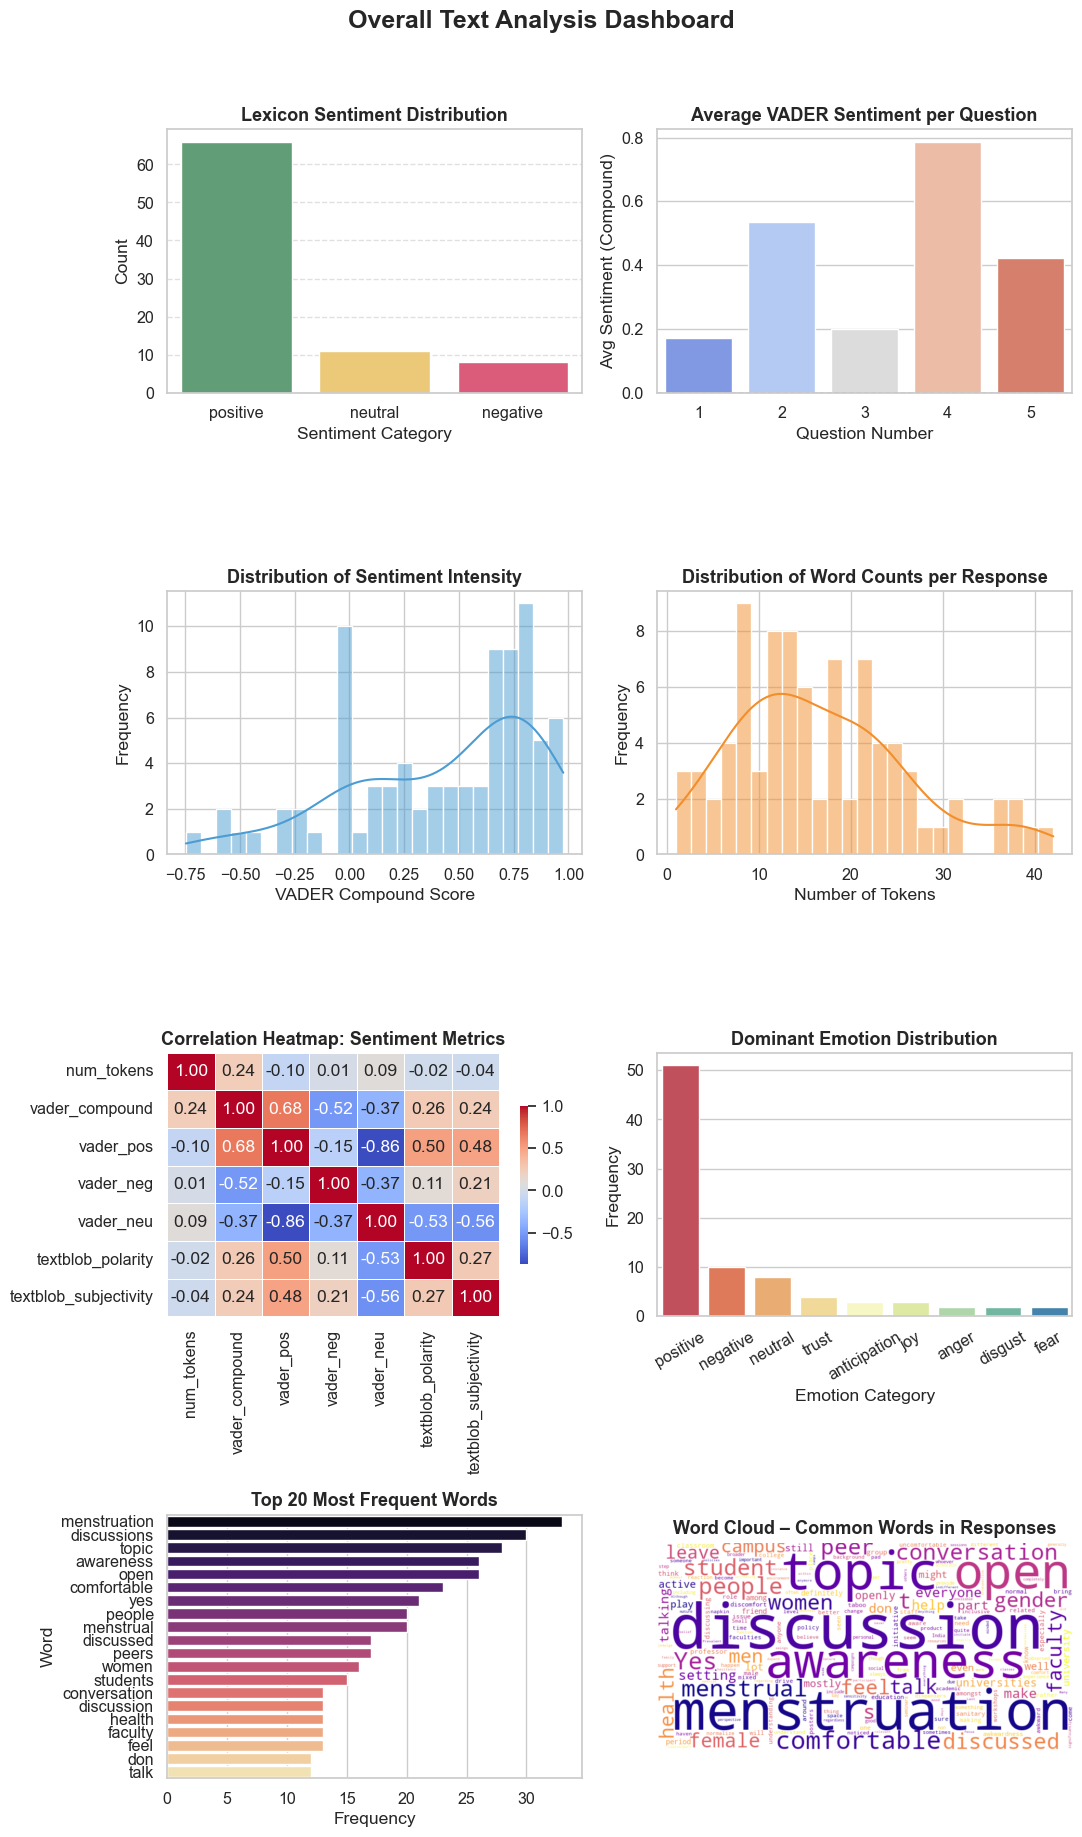

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

# Seaborn style settings
sns.set(style="whitegrid", font_scale=1.05)
plt.rcParams['axes.facecolor'] = 'white'

# -------------------------------
# Prepare Supporting Data
# -------------------------------
# 1. Average Sentiment per Question
q_mean = df.groupby('question_no')['vader_compound'].agg(['mean', 'count']).reset_index()

# 2. Correlation Matrix
corr_cols = [
    'num_tokens', 'vader_compound', 'vader_pos', 'vader_neg', 'vader_neu',
    'textblob_polarity', 'textblob_subjectivity'
]
corr_matrix = df[corr_cols].corr()

# 3. Top 20 Words
cv = CountVectorizer(stop_words='english', max_features=20)
word_counts = np.sum(cv.fit_transform(df['clean_answer']).toarray(), axis=0)
words = cv.get_feature_names_out()
word_freq = pd.DataFrame({'word': words, 'count': word_counts}).sort_values('count', ascending=False)

# Create Subplot Grid

fig, axes = plt.subplots(4, 2, figsize=(11, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.35)
axes = axes.flatten()

# Sentiment Distribution
palette = ['#57A773', '#FFD166', '#EF476F']
sns.countplot(data=df, x='lex_label', order=['positive','neutral','negative'],
              palette=palette, ax=axes[0])
axes[0].set_title('Lexicon Sentiment Distribution', fontsize=13, weight='bold')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Average Sentiment by Question
sns.barplot(data=q_mean, x='question_no', y='mean', palette='coolwarm', ax=axes[1])
axes[1].axhline(0, color='black', linestyle='--', lw=1)
axes[1].set_title('Average VADER Sentiment per Question', fontsize=13, weight='bold')
axes[1].set_xlabel('Question Number')
axes[1].set_ylabel('Avg Sentiment (Compound)')

# Sentiment Intensity Distribution
sns.histplot(df['vader_compound'], bins=25, kde=True, color='#4B9CD3', ax=axes[2])
axes[2].set_title('Distribution of Sentiment Intensity', fontsize=13, weight='bold')
axes[2].set_xlabel('VADER Compound Score')
axes[2].set_ylabel('Frequency')

# Word Count Distribution
sns.histplot(df['num_tokens'], bins=25, kde=True, color='#f28e2b', ax=axes[3])
axes[3].set_title('Distribution of Word Counts per Response', fontsize=13, weight='bold')
axes[3].set_xlabel('Number of Tokens')
axes[3].set_ylabel('Frequency')

# Correlation Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.4,
            cbar_kws={'shrink':0.6}, ax=axes[4])
axes[4].set_title('Correlation Heatmap: Sentiment Metrics', fontsize=13, weight='bold')

# Emotion Distribution
sns.countplot(data=df, x='dominant_emotion',
              order=df['dominant_emotion'].value_counts().index,
              palette='Spectral', ax=axes[5])
axes[5].set_title('Dominant Emotion Distribution', fontsize=13, weight='bold')
axes[5].set_xlabel('Emotion Category')
axes[5].set_ylabel('Frequency')
axes[5].tick_params(axis='x', rotation=30)

# Top 20 Most Frequent Words
sns.barplot(data=word_freq, x='count', y='word', palette='magma', ax=axes[6])
axes[6].set_title('Top 20 Most Frequent Words', fontsize=13, weight='bold')
axes[6].set_xlabel('Frequency')
axes[6].set_ylabel('Word')

# Word Cloud
all_text = " ".join(df['clean_answer'].tolist())
wc = WordCloud(
    width=800, height=400, background_color='white',
    colormap='plasma', collocations=False,
    contour_color='steelblue', contour_width=1.2
).generate(all_text)

axes[7].imshow(wc, interpolation='bilinear')
axes[7].axis('off')
axes[7].set_title('Word Cloud – Common Words in Responses', fontsize=13, weight='bold')

plt.suptitle('Overall Text Analysis Dashboard', fontsize=18, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


#### Word Clouds per Question

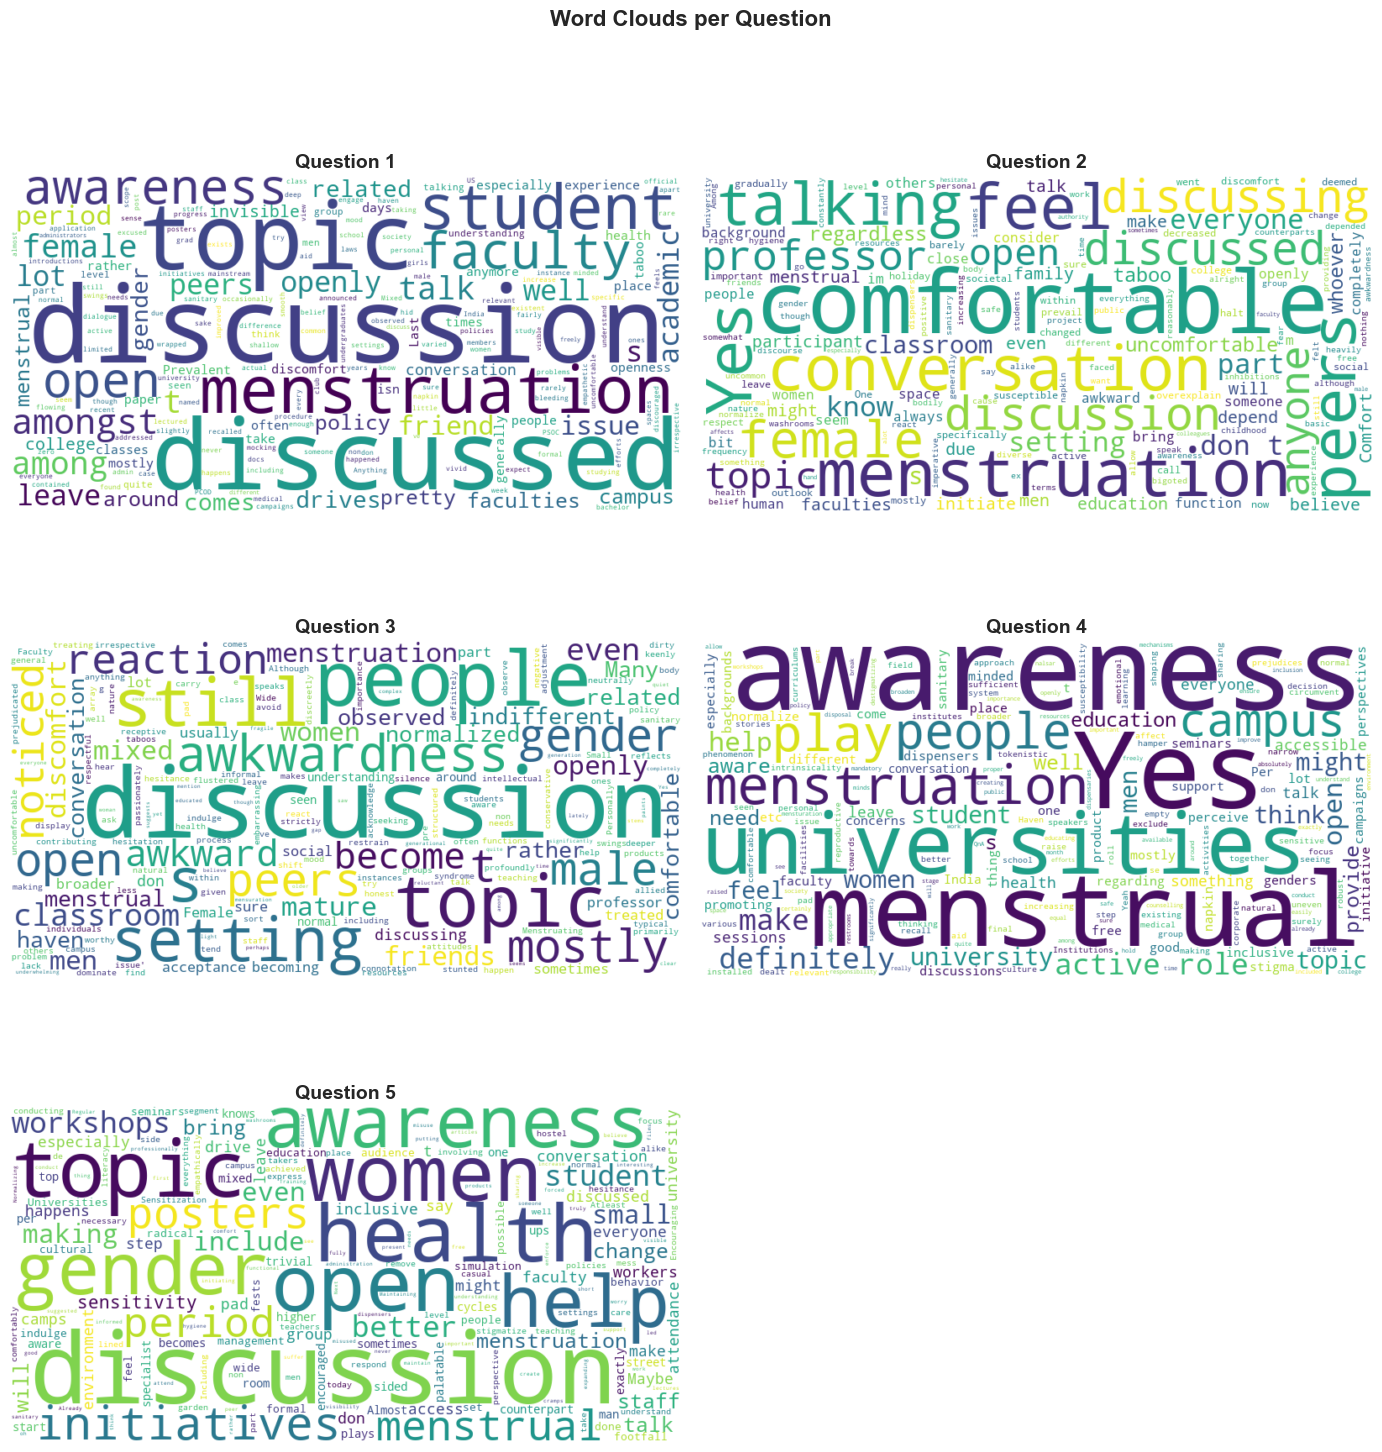

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Group by question and combine text
grouped_text = df.groupby('question_no')['clean_answer'].apply(lambda x: " ".join(x)).reset_index()

# Define subplot grid
n_questions = grouped_text.shape[0]
n_cols = 2
n_rows = (n_questions + 1) // n_cols

plt.figure(figsize=(14, 5 * n_rows))
sns.set_style("white")

for i, row in enumerate(grouped_text.itertuples(), 1):
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis',
        contour_color='steelblue',
        contour_width=1
    ).generate(row.clean_answer)
    
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Question {row.question_no}', fontsize=14, weight='bold')

plt.suptitle('Word Clouds per Question', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


### PART A: Sentiment Analysis

#### Lexicon-based Sentiment Analysis

lex_label    negative   neutral  positive
question_no                              
1            0.176471  0.235294  0.588235
2            0.058824  0.117647  0.823529
3            0.235294  0.058824  0.705882
4            0.000000  0.000000  1.000000
5            0.000000  0.235294  0.764706


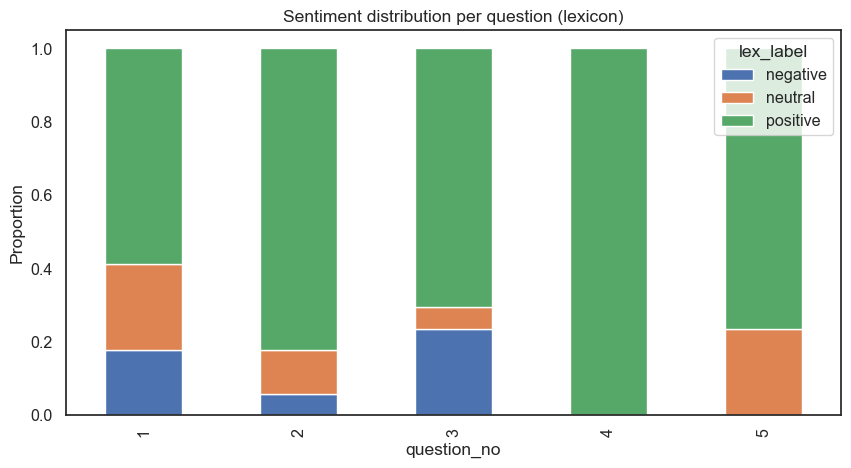

In [68]:
def lexicon_sentiment(text):
    v = vader.polarity_scores(text)
    tb = TextBlob(text)
    return pd.Series({
        'vader_compound': v['compound'],
        'vader_pos': v['pos'],
        'vader_neg': v['neg'],
        'textblob_polarity': tb.sentiment.polarity,
        'textblob_subjectivity': tb.sentiment.subjectivity
    })

sent_df = df['clean_answer'].apply(lexicon_sentiment)
df = pd.concat([df, sent_df], axis=1)

# Ensemble label
def ensemble_label(row, pos_thresh=0.05, neg_thresh=-0.05):
    avg = (row['vader_compound'] + row['textblob_polarity']) / 2.0
    if avg >= pos_thresh:
        return 'positive'
    elif avg <= neg_thresh:
        return 'negative'
    else:
        return 'neutral'

df['lex_label'] = df.apply(ensemble_label, axis=1)

# Aggregation per question number
q_sent = df.groupby('question_no')['lex_label'].value_counts(normalize=True).unstack(fill_value=0)
print(q_sent)
q_sent.plot(kind='bar', stacked=True, figsize=(10,5), title='Sentiment distribution per question (lexicon)')
plt.ylabel('Proportion')
plt.show()

#### Word Clouds by Sentiment Category

<Figure size 1800x600 with 0 Axes>

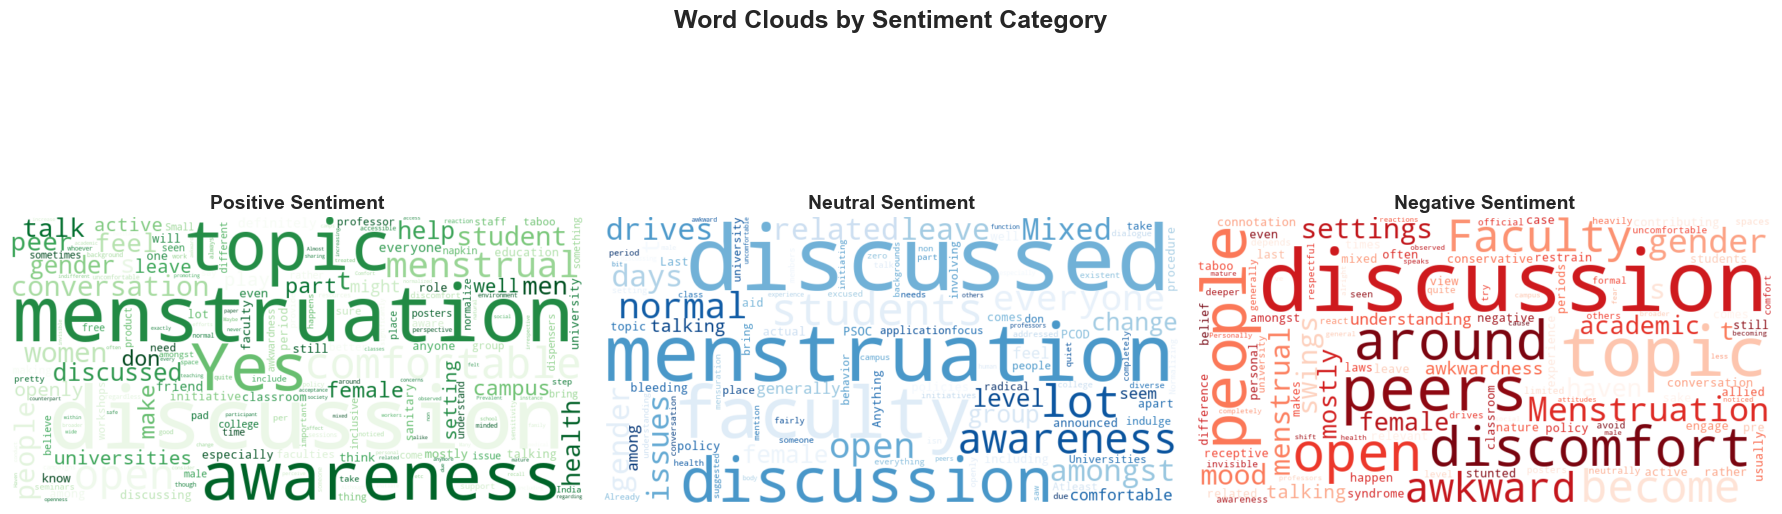

In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Define figure style
plt.figure(figsize=(18, 6))

# Define the sentiments you want to visualize
sentiments = ['positive', 'neutral', 'negative']
colors = ['Greens', 'Blues', 'Reds']  # color maps for each sentiment

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Word Clouds by Sentiment Category', fontsize=18, weight='bold', y=1.05)

# Generate a word cloud for each sentiment
for ax, sentiment, cmap in zip(axes, sentiments, colors):
    text = " ".join(df.loc[df['lex_label'] == sentiment, 'clean_answer'].dropna())
    
    # Handle empty cases gracefully
    if len(text.strip()) == 0:
        ax.text(0.5, 0.5, f'No data for {sentiment}', 
                ha='center', va='center', fontsize=14, color='gray')
        ax.axis('off')
        continue

    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap=cmap,
                   collocations=False,
                   contour_color='black',
                   contour_width=1.2).generate(text)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{sentiment.capitalize()} Sentiment', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

#### Sentiment and Emotion Extraction from vader and TextBlob


In [70]:
# Sentiment and Emotion Extraction
def enrich_sentiment(text):
    v = vader.polarity_scores(text)
    tb = TextBlob(text)
    return pd.Series({
        'vader_compound': v['compound'],
        'vader_pos': v['pos'],
        'vader_neg': v['neg'],
        'vader_neu': v['neu'],
        'textblob_polarity': tb.sentiment.polarity,
        'textblob_subjectivity': tb.sentiment.subjectivity
    })

sent_df = df['clean_answer'].apply(enrich_sentiment)
df = pd.concat([df, sent_df], axis=1)

#### Ensemble Sentiment Labeling

In [71]:
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_answer'] = df['answer'].apply(clean_text)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

vader = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    v = vader.polarity_scores(text)
    tb = TextBlob(text)
    return pd.Series({
        'vader_compound': v['compound'],
        'vader_pos': v['pos'],
        'vader_neg': v['neg'],
        'textblob_polarity': tb.sentiment.polarity,
        'textblob_subjectivity': tb.sentiment.subjectivity
    })

sent_df = df['clean_answer'].apply(sentiment_scores)
df = pd.concat([df, sent_df], axis=1)

In [72]:
# Drop duplicate column names (keep the first occurrence)
df = df.loc[:, ~df.columns.duplicated()]
print(df.columns.tolist())

['q_label', 'question', 'a_label', 'answer', 'file', 'path', 'interview_id', 'question_no', 'clean_answer', 'tokens', 'num_tokens', 'short_answer', 'vader_compound', 'vader_pos', 'vader_neg', 'textblob_polarity', 'textblob_subjectivity', 'lex_label', 'vader_neu']


C:\Users\BHAVYA\AppData\Local\Temp\ipykernel_20716\480722400.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




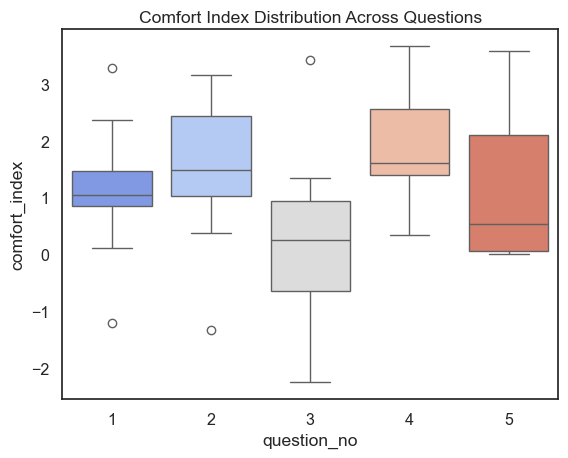

In [73]:
def ensemble_label(row, pos_thresh=0.05, neg_thresh=-0.05):
    v = float(row['vader_compound'])
    t = float(row['textblob_polarity'])
    avg = (v + t) / 2.0
    if avg >= pos_thresh:
        return 'positive'
    elif avg <= neg_thresh:
        return 'negative'
    else:
        return 'neutral'

df['lex_label'] = df.apply(ensemble_label, axis=1)

positive_terms = r'\bcomfortable|open|aware|positive|supportive|accepting|free\b'
negative_terms = r'\bawkward|hesitant|uncomfortable|taboo|shy|embarrassed\b'

df['comfort_index'] = (
    (df['vader_compound'] + df['textblob_polarity']) / 2 +
    df['clean_answer'].str.count(positive_terms, flags=re.IGNORECASE) -
    df['clean_answer'].str.count(negative_terms, flags=re.IGNORECASE)
)

sns.boxplot(data=df, x='question_no', y='comfort_index', palette='coolwarm')
plt.title('Comfort Index Distribution Across Questions')
plt.show()

#### Semantic Clustering with UMAP + HDBSCAN


C:\Users\BHAVYA\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\BHAVYA\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\BHAVYA\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




 Top Terms by Cluster (auto-labeled)

Cluster -1 (Women / Topic / Making): women, topic, making, discussion, female, initiatives, hesitance, spaces
Cluster 0 (Menstruation / Discussed / Talk): menstruation, discussed, talk, leave, openly, discussions, peers, menstrual
Cluster 1 (Play Active / Play / Menstrual): play active, play, menstrual, role, active role, campus, awareness, active
Cluster 2 (Having / Universities / Like Having): having, universities, like having, making, yes, change, better, normal
Cluster 3 (Workshops / Health / Health Workshops): workshops, health, health workshops, awareness, camps, sharing, workers, awareness camps
Cluster 4 (Classroom / Discussions / Open): classroom, discussions, open, times, faculty, students, classroom discussions, taboo
Cluster 5 (Know / Comfortable / Women): know, comfortable, women, conversation, don know, noticed, female, seen
Cluster 6 (Comfortable / Yes / Talking): comfortable, yes, talking, im, participant, conversation yes, convers

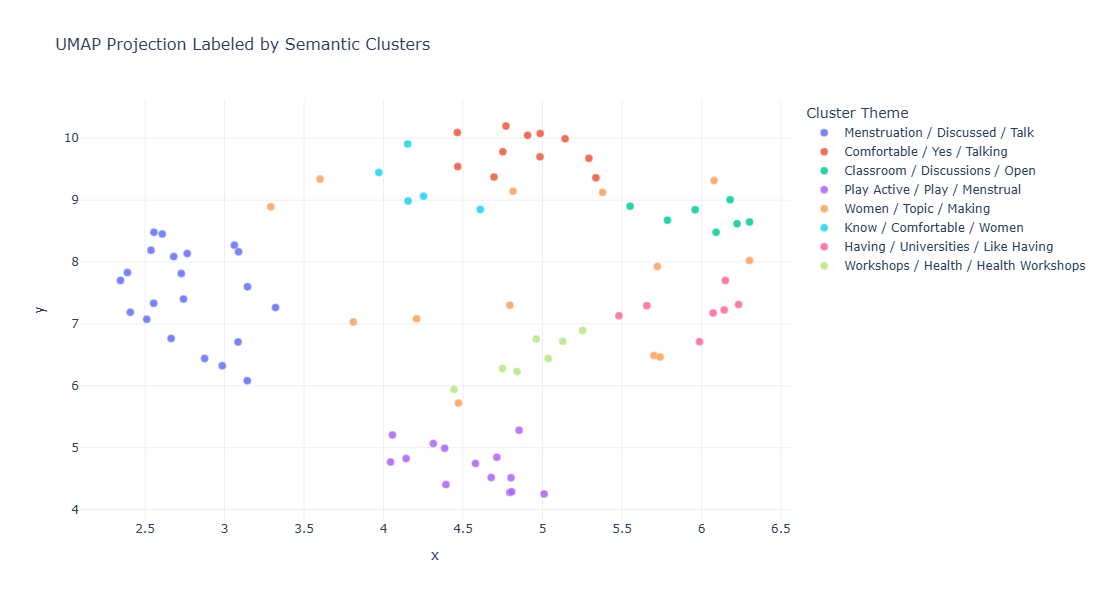

In [74]:
# --- Imports ---
import umap
import hdbscan
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Normalize embeddings ---
embeddings_scaled = StandardScaler().fit_transform(embeddings)

# --- UMAP dimensionality reduction ---
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.05,
    n_components=2,
    random_state=RANDOM_STATE,
    metric='cosine'
)
umap_emb = umap_reducer.fit_transform(embeddings_scaled)

# --- HDBSCAN clustering ---
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(umap_emb)
df['embed_cluster'] = cluster_labels

# --- c-TF-IDF keyword extraction per cluster ---
cluster_docs = (
    df.groupby('embed_cluster')['clean_answer']
    .apply(lambda s: " ".join(s))
    .to_dict()
)

ctfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words='english',
    max_features=3000
)
cluster_matrix = ctfidf.fit_transform(cluster_docs.values())
terms = np.array(ctfidf.get_feature_names_out())

# --- Identify top terms + assign human-readable labels ---
cluster_names = {}
print("\n Top Terms by Cluster (auto-labeled)\n")
for i, label in enumerate(cluster_docs.keys()):
    row = cluster_matrix[i].toarray().ravel()
    top = row.argsort()[-8:][::-1]
    top_terms = [terms[j] for j in top]

    # Generate simple descriptive cluster name (use 2–3 keywords)
    cluster_label = " / ".join(top_terms[:3]).title()
    cluster_names[label] = cluster_label

    print(f"Cluster {label} ({cluster_label}): {', '.join(top_terms)}")

# --- Add readable cluster names back to dataframe ---
df['cluster_name'] = df['embed_cluster'].map(cluster_names)

# --- Interactive visualization (Plotly) ---
fig = px.scatter(
    x=umap_emb[:, 0],
    y=umap_emb[:, 1],
    color=df['cluster_name'],
    hover_data={
        'interview_id': df['interview_id'],
        'short_answer': df['short_answer']
    },
    title='UMAP Projection Labeled by Semantic Clusters'
)
fig.update_traces(marker=dict(size=8, opacity=0.85, line=dict(width=0.4, color='white')))
fig.update_layout(
    title_font_size=16,
    legend_title_text='Cluster Theme',
    width=950, height=600,
    template='plotly_white'
)
fig.show()

### PART B: Thematic Analysis

#### TF-IDF, Embeddings, and Feature Matrices

In [75]:
# TF-IDF for answers (for modeling / topic extraction)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9, max_features=3000)
X_tfidf = tfidf.fit_transform(df['clean_answer'])

# Sentence embeddings (semantic)
embed_model = SentenceTransformer('all-MiniLM-L6-v2')  # fast & effective
embeddings = embed_model.encode(df['clean_answer'].tolist(), show_progress_bar=True, convert_to_numpy=True)
print('Embeddings shape:', embeddings.shape)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings shape: (85, 384)


#### Topic Modeling with LDA

In [76]:
# Prepare gensim dictionary & corpus
texts = df['tokens'].tolist()
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=2, no_above=0.8, keep_n=5000)
gensim_corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA (choose topic count 4-8, here 6 as default; you can compute coherence to choose)
NUM_TOPICS = 6
lda = gensim.models.LdaModel(corpus=gensim_corpus,
                             id2word=dictionary,
                             num_topics=NUM_TOPICS,
                             random_state=RANDOM_STATE,
                             chunksize=100,
                             passes=20,
                             alpha='auto',
                             per_word_topics=True)

for tid in range(NUM_TOPICS):
    terms = lda.show_topic(tid, topn=12)
    print(f"Topic {tid}: ", ", ".join([t for t,_ in terms]))

Topic 0:  discussion, topic, health, menstrual, woman, gender, people, setting, notice, menstruation, open, leave
Topic 1:  awkwardness, peer, help, topic, awareness, open, talk, friend, change, comfort, create, definitely
Topic 2:  talk, peer, discuss, comfortable, topic, openly, conversation, menstruation, feel, female, people, faculty
Topic 3:  menstruation, talk, discussion, know, student, people, gender, conversation, comfortable, include, awareness, feel
Topic 4:  discuss, awareness, menstruation, comfortable, lot, discussion, university, open, conversation, female, faculty, feel
Topic 5:  open, university, menstrual, play, student, topic, active, awareness, role, discussion, faculty, leave


#### Dominant Topic Mapping

In [77]:
# Step 1: Assign dominant LDA topic to each document
lda_topic_ids = []
lda_topic_probs = []

for i, corp in enumerate(gensim_corpus):
    topic_distribution = lda.get_document_topics(corp)
    
    # Pick the topic with the highest probability
    dominant_topic, prob = max(topic_distribution, key=lambda x: x[1])
    
    lda_topic_ids.append(dominant_topic)
    lda_topic_probs.append(prob)

# Step 2: Add results to your dataframe
df['lda_topic_ids'] = lda_topic_ids
df['lda_topic_prob'] = lda_topic_probs  # optional confidence metric

# Step 3: Define topic names and keywords (based on your inspection)
topic_names = {
    0: "Menstrual Health & Gender Conversations",
    1: "Peer Awareness & Comfort Building",
    2: "Open Dialogue and Communication",
    3: "Student Experience & Awareness",
    4: "Institutional Support & Faculty Role",
    5: "University Engagement & Advocacy"
}

topic_keywords = {
    0: ["discussion", "topic", "health", "menstrual", "woman", "gender", "people", "setting", "notice", "menstruation", "open", "leave"],
    1: ["awkwardness", "peer", "help", "topic", "awareness", "open", "talk", "friend", "change", "comfort", "create", "definitely"],
    2: ["talk", "peer", "discuss", "comfortable", "topic", "openly", "conversation", "menstruation", "feel", "female", "people", "faculty"],
    3: ["menstruation", "talk", "discussion", "know", "student", "people", "gender", "conversation", "comfortable", "include", "awareness", "feel"],
    4: ["discuss", "awareness", "menstruation", "comfortable", "lot", "discussion", "university", "open", "conversation", "female", "faculty", "feel"],
    5: ["open", "university", "menstrual", "play", "student", "topic", "active", "awareness", "role", "discussion", "faculty", "leave"]
}

# Step 4: Map topic names and keywords
df['Topic_Name'] = df['lda_topic_ids'].map(topic_names)
df['Top_Keywords'] = df['lda_topic_ids'].map(lambda x: ', '.join(topic_keywords[x]))

# Step 5: Quick sanity check
df[['clean_answer', 'lda_topic_ids', 'Topic_Name', 'lda_topic_prob']].head()

,clean_answer,lda_topic_ids,Topic_Name,lda_topic_prob
0,"Students, a lot. Faculty not a lot. Lot of dis...",4,Institutional Support & Faculty Role,0.623128
1,"Yes, comfortable with peers, faculties, classr...",4,Institutional Support & Faculty Role,0.980489
2,"Faculty has become more open about this, but t...",2,Open Dialogue and Communication,0.861994
3,Haven’t seen any menstrual aware campus in Ind...,5,University Engagement & Advocacy,0.534975
4,Small initiatives like gender talks should inc...,3,Student Experience & Awareness,0.988129


#### LDA Topic Distribution

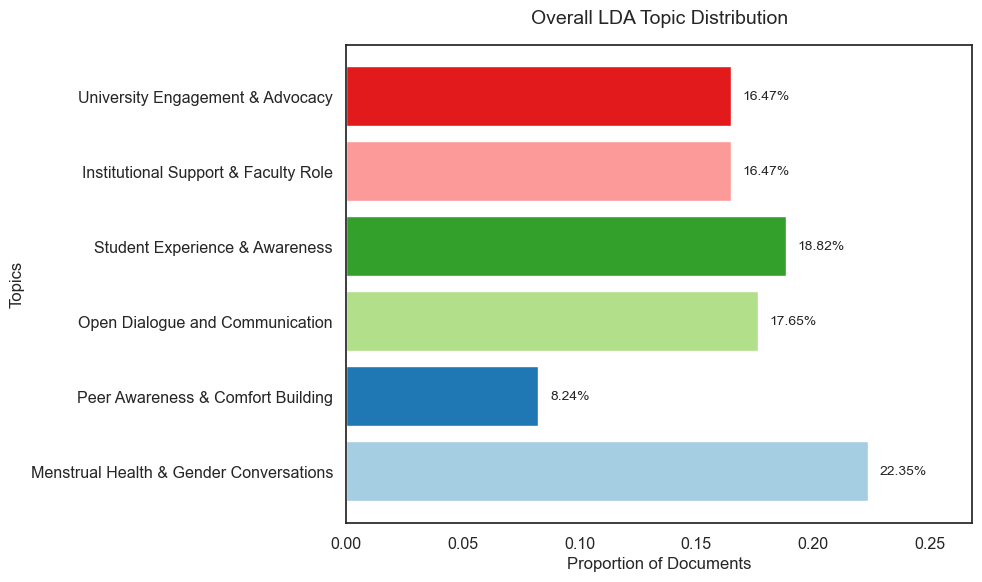

In [78]:
# --- Compute topic frequency using numeric topic IDs ---
topic_counts = df['lda_topic_ids'].value_counts().sort_index()
topic_props = topic_counts / topic_counts.sum()

# --- Map topic IDs to names ---
topic_labels = [topic_names[i] for i in topic_counts.index]

# --- Plot overall distribution ---
plt.figure(figsize=(10,6))
bars = plt.barh(topic_labels, topic_props, color=plt.cm.Paired.colors)

# --- Add text annotations ---
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{width:.2%}", va='center', fontsize=10)

# --- Style and labels ---
plt.title("Overall LDA Topic Distribution", fontsize=14, pad=15)
plt.xlabel("Proportion of Documents", fontsize=12)
plt.ylabel("Topics", fontsize=12)
plt.xlim(0, max(topic_props)*1.2)
plt.tight_layout()
plt.show()

##### LDA Topic Distribution by Question


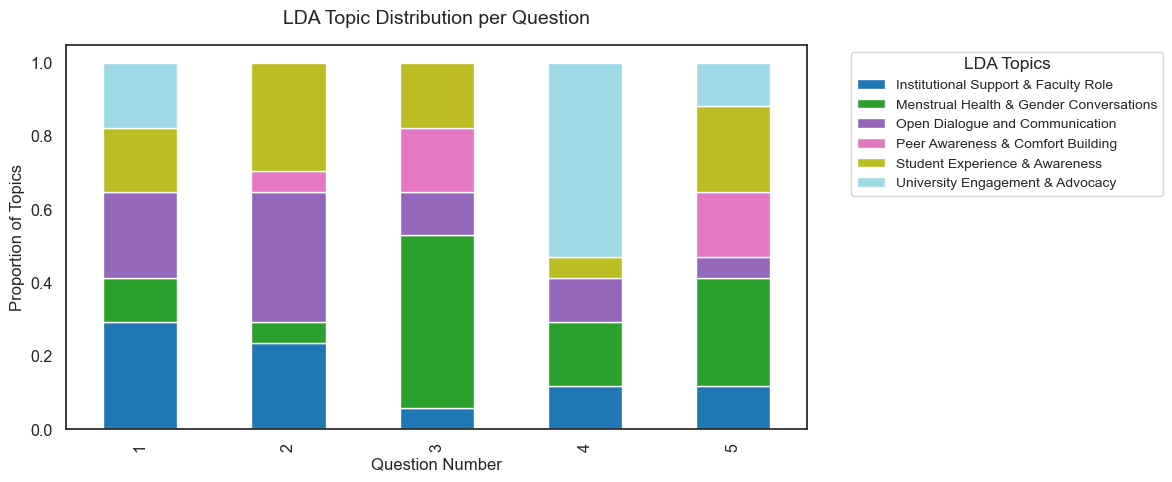

In [79]:
# Compute topic distribution by question
topic_dist = pd.crosstab(df['question_no'], df['Topic_Name'], normalize='index').fillna(0)

# Replace topic indices with topic names
topic_dist.rename(columns=topic_names, inplace=True)

# Plot with clear labels and title
topic_dist.plot(kind='bar', stacked=True, figsize=(12,5), colormap='tab20')

plt.title('LDA Topic Distribution per Question', fontsize=14, pad=15)
plt.xlabel('Question Number', fontsize=12)
plt.ylabel('Proportion of Topics', fontsize=12)
plt.legend(title='LDA Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

#### NMF Topic Modeling and Visualization

In [80]:
vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(df['clean_answer'])
nmf_model = NMF(n_components=5, random_state=RANDOM_STATE)
W = nmf_model.fit_transform(tfidf)
H = nmf_model.components_
terms = vectorizer.get_feature_names_out()

# Top words per theme
for i, topic in enumerate(H):
    print(f"\nTopic {i+1}: ", " | ".join([terms[j] for j in topic.argsort()[:-11:-1]]))


Topic 1:  discussions | open | topic | discussion | peers | settings | classroom | mixed | people | leave

Topic 2:  comfortable | yes | feel | discussing | regardless | conversation | talking | peers | uncomfortable | bit

Topic 3:  health | workshops | awareness | menstrual | help | staff | students | sensitivity | inclusive | definitely

Topic 4:  women | men | universities | play | yes | active | role | people | minded | concerns

Topic 5:  discussed | menstruation | openly | awareness | campus | talk | level | lot | place | faculty


##### Topic Mapping and Visualization


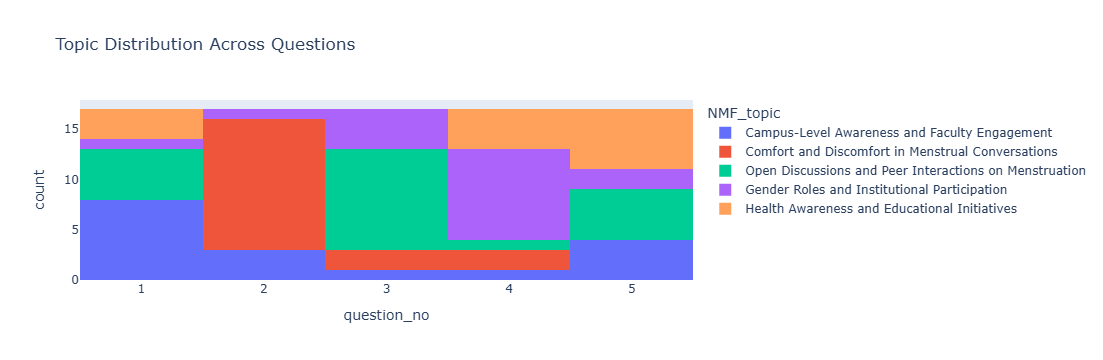

In [81]:
# Define topic names based on interpretation
topic_name_map = {
    0: "Open Discussions and Peer Interactions on Menstruation",
    1: "Comfort and Discomfort in Menstrual Conversations",
    2: "Health Awareness and Educational Initiatives",
    3: "Gender Roles and Institutional Participation",
    4: "Campus-Level Awareness and Faculty Engagement"
}

# Assign most dominant topic to each document (NMF example)
topic_labels = [topic_name_map[i] for i in np.argmax(W, axis=1)]
df['NMF_topic'] = topic_labels

px.histogram(df, x='question_no', color='NMF_topic',
             title='Topic Distribution Across Questions').show()

### Other Visualizations


#### Keyword Co-occurrence Network

In [82]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['clean_answer'].tolist(), show_progress_bar=False)

umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(umap_embeddings)
df['semantic_cluster'] = cluster_labels

C:\Users\BHAVYA\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\BHAVYA\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



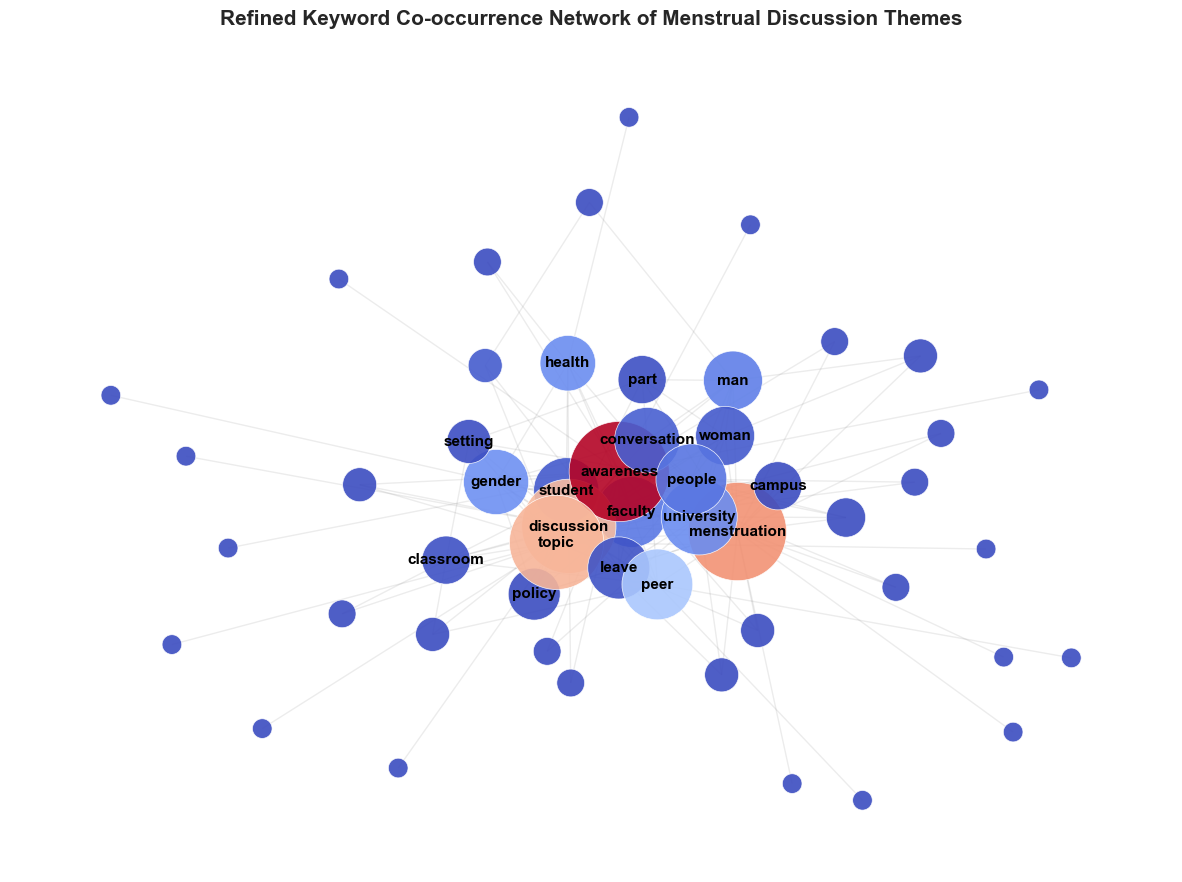

In [83]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import numpy as np

# --- Step 1. Build edges from text ---
edges = []
for ans in df['clean_answer']:
    doc = nlp(ans.lower())
    nouns = [tok.lemma_ for tok in doc if tok.pos_ in ['NOUN', 'PROPN']]
    for comb in combinations(set(nouns), 2):
        edges.append(tuple(sorted(comb)))

edge_freq = Counter(edges)

# --- Step 2. Create Graph (filter weak connections) ---
G = nx.Graph()
for (a, b), w in edge_freq.items():
    if w >= 3:   # slightly stricter filter
        G.add_edge(a, b, weight=w)

# --- Step 3. Compute network metrics ---
degree_dict = dict(G.degree())
betweenness = nx.betweenness_centrality(G)
pos = nx.spring_layout(G, k=1.5, iterations=100, seed=42)

# --- Step 4. Simplify visuals ---
# Show only top 20 most connected keywords
top_keywords = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]
labels = {node: node if node in top_keywords else '' for node in G.nodes()}

# --- Step 5. Styling ---
plt.figure(figsize=(12, 9))

# Draw edges faintly
nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color='gray')

# Node size scaled down for balance
node_sizes = np.array([degree_dict[n] for n in G.nodes()]) * 200
node_colors = np.array([betweenness[n] for n in G.nodes()])

# Use a perceptually balanced color map
nx.draw_networkx_nodes(G, pos, 
                       node_size=node_sizes, 
                       node_color=node_colors,
                       cmap=plt.cm.coolwarm,
                       alpha=0.9,
                       edgecolors='white',
                       linewidths=0.5)

nx.draw_networkx_labels(G, pos, labels=labels, 
                        font_size=11, font_weight='semibold', font_color='black')

plt.title('Refined Keyword Co-occurrence Network of Menstrual Discussion Themes', 
          fontsize=15, fontweight='bold', pad=15)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Emotion Analysis with NRCLex

In [46]:
!python -m textblob.download_corpora

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews 

In [84]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\BHAVYA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

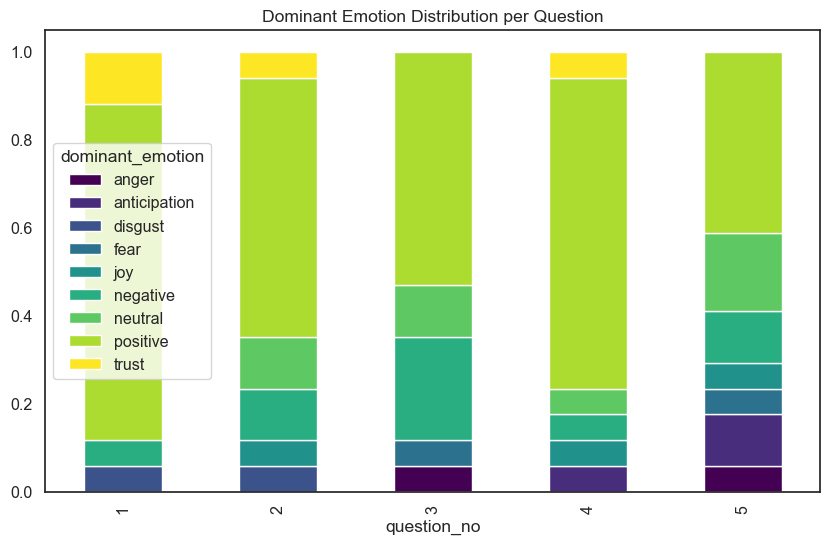

In [85]:
from nrclex import NRCLex
def get_dominant_emotion(text):
    emo = NRCLex(text)
    if emo.raw_emotion_scores:
        return max(emo.raw_emotion_scores, key=emo.raw_emotion_scores.get)
    else:
        return 'neutral'

df['dominant_emotion'] = df['clean_answer'].apply(get_dominant_emotion)

emo_dist = df.groupby('question_no')['dominant_emotion'].value_counts(normalize=True).unstack(fill_value=0)
emo_dist.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title('Dominant Emotion Distribution per Question')
plt.show()

### PART C: Concluding Interactive Dashboard


In [339]:
!pip uninstall plotly -y
!pip install plotly==5.22.0

Found existing installation: plotly 6.3.1
Uninstalling plotly-6.3.1:
  Successfully uninstalled plotly-6.3.1
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ----- ---------------------------------- 2.4/16.4 MB 13.4 MB/s eta 0:00:02
   ---------- ----------------------------- 4.2/16.4 MB 11.0 MB/s eta 0:00:02
   -------------- ------------------------- 5.8/16.4 MB 9.5 MB/s eta 0:00:02
   ------------------- -------------------- 7.9/16.4 MB 9.5 MB/s eta 0:00:01
   --------------------- ------------------ 8.9/16.4 MB 8.7 MB/s eta 0:00:01
   ---------------------------- ----------- 11.8/16.4 MB 9.5 MB/s eta 0:00:01
   ----------------------------------- ---- 14.4/16.4 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  16.3/16.4 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 9.8 MB/s eta 0:00:00


In [86]:
# --- DASHBOARD CODE (with Robust Sentiment Handling & Global Filter) ---

import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import io
import base64

# --- Step 0: Ensure Sentiment Column Exists ---
# If 'sentiment' column missing, derive it intelligently
if 'sentiment' not in df.columns:
    if 'lex_label' in df.columns:
        df['sentiment'] = df['lex_label']
    elif 'vader_compound' in df.columns:
        def get_sentiment(score):
            if score >= 0.05:
                return 'Positive'
            elif score <= -0.05:
                return 'Negative'
            else:
                return 'Neutral'
        df['sentiment'] = df['vader_compound'].apply(get_sentiment)
    else:
        df['sentiment'] = 'Neutral'  # fallback default

# --- Step 1: Sentiment Distribution (Static) ---
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

fig_sentiment = px.bar(
    sentiment_counts,
    x='Sentiment',
    y='Count',
    color='Sentiment',
    title='Sentiment Distribution (Overall)',
    text='Count'
)

# --- Helper: Generate WordCloud for given data subset ---
def generate_wordcloud(text_data):
    text = " ".join(text_data.astype(str))
    if not text.strip():
        text = "No data available for this selection."
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    buf = io.BytesIO()
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(buf, format="png")
    plt.close()
    encoded = base64.b64encode(buf.getvalue()).decode()
    return f"data:image/png;base64,{encoded}"

# --- Step 2: Initialize Dash App ---
app = dash.Dash(__name__)

# --- Step 3: Layout ---
app.layout = html.Div([
    html.H1("Menstruation Discussion Sentiment & Topic Analysis Dashboard",
            style={'textAlign': 'center', 'marginBottom': '20px'}),

    html.Div([
        html.Label("🔍 Filter Dashboard by Sentiment:", style={'fontWeight': 'bold', 'fontSize': '16px'}),
        dcc.Dropdown(
            id='main_sentiment_filter',
            options=[{'label': s, 'value': s} for s in sorted(df['sentiment'].unique())] +
                    [{'label': 'All', 'value': 'All'}],
            value='All',
            clearable=False,
            style={'width': '50%', 'marginBottom': '30px'}
        )
    ], style={'textAlign': 'center'}),

    # Row 1: Sentiment & Topic
    html.Div([
        html.Div([dcc.Graph(figure=fig_sentiment)], className='six columns'),
        html.Div([dcc.Graph(id='topic_dist_graph')], className='six columns'),
    ], className='row'),

    # Row 2: Emotion & WordCloud
    html.Div([
        html.Div([dcc.Graph(id='emotion_dist_graph')], className='six columns'),
        html.Div([
            html.Img(id='sentiment_wc', style={'width': '100%', 'marginTop': '20px'})
        ], className='six columns'),
    ], className='row'),

    html.H3("Topic-wise Sentiment & Emotion Table", style={'marginTop': '40px'}),
    dash_table.DataTable(
        id='topic_table',
        columns=[{'name': i, 'id': i} for i in ['Topic_Name', 'sentiment', 'dominant_emotion']],
        page_size=8,
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'center', 'padding': '10px'},
        style_header={'backgroundColor': '#f0f0f0', 'fontWeight': 'bold'}
    )
])

# --- Step 4: Callbacks for Interactivity ---
@app.callback(
    [Output('topic_dist_graph', 'figure'),
     Output('emotion_dist_graph', 'figure'),
     Output('sentiment_wc', 'src'),
     Output('topic_table', 'data')],
    Input('main_sentiment_filter', 'value')
)
def update_dashboard(selected_sentiment):
    # --- Filter Data ---
    if selected_sentiment == 'All':
        filtered_df = df.copy()
    else:
        filtered_df = df[df['sentiment'] == selected_sentiment]

    # --- Topic Distribution ---
    topic_counts = filtered_df['Topic_Name'].value_counts().reset_index()
    topic_counts.columns = ['Topic', 'Count']
    fig_topic = px.bar(
        topic_counts,
        x='Topic',
        y='Count',
        color='Topic',
        title=f"Topic Distribution ({selected_sentiment})" if selected_sentiment != 'All' else "Topic Distribution (All)",
        text='Count'
    )
    fig_topic.update_xaxes(tickangle=45)

    # --- Emotion Distribution ---
    emotion_counts = filtered_df['dominant_emotion'].value_counts().reset_index()
    emotion_counts.columns = ['Emotion', 'Count']
    fig_emotion = px.pie(
        emotion_counts,
        names='Emotion',
        values='Count',
        title=f"Dominant Emotion Distribution ({selected_sentiment})" if selected_sentiment != 'All' else "Dominant Emotion Distribution (All)"
    )

    # --- WordCloud ---
    wc_src = generate_wordcloud(filtered_df['clean_answer'])

    # --- Table Data ---
    table_data = filtered_df[['Topic_Name', 'sentiment', 'dominant_emotion']].to_dict('records')

    return fig_topic, fig_emotion, wc_src, table_data

# --- Step 5: Run App ---
if __name__ == '__main__':
    app.run(debug=True, port=8051)
